# UniProt Sequence Coverage by 3D Structures in PDB

This notebook determines the coverage of UniProtKB sequences on a per protein chain basis for protein structures in the PDB.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

## Get UniProtKB Data
UniProt id, preferred gene name, and sequence length ([see column names for RESTful web services](https://www.uniprot.org/help/uniprotkb_column_names)).

In [2]:
taxonomy_id = 9606
columns = 'id,genes(PREFERRED),length'

In [3]:
url = f'https://www.uniprot.org/uniprot/?query=organism:{taxonomy_id}&columns={columns}&format=tab'

In [4]:
unp = pd.read_csv(url, sep='\t')
unp.rename(columns={'Gene names  (primary )': 'GENE'}, inplace=True)  ## create name without spaces
unp.head()

,Entry,GENE,Length
0,Q66K14,TBC1D9B,1250
1,Q9UMR3,TBX20,447
2,Q9P031,CCDC59,241
3,Q6PEY2,TUBA3E,450
4,Q9P016,THYN1,225


In [5]:
print('Unique proteins: ', len(unp['Entry'].unique()), 'for organism:', taxonomy_id)
print('Unique genes   : ', len(unp['GENE'].unique()), 'for organism:', taxonomy_id)

Unique proteins:  196111 for organism: 9606
Unique genes   :  26806 for organism: 9606


## Get UniProt segments covered by PDB residues
Get continuous segments of the UniProt sequence covered by PDB residues from EBI [SIFTS](https://www.ebi.ac.uk/pdbe/docs/sifts/) project.

In [6]:
sifts_url = 'http://ftp.ebi.ac.uk/pub/databases/msd/sifts/flatfiles/tsv/uniprot_segments_observed.tsv.gz'

In [7]:
segments = pd.read_csv(sifts_url, sep='\t', skiprows=1)
segments.head()

,PDB,CHAIN,SP_PRIMARY,RES_BEG,RES_END,PDB_BEG,PDB_END,SP_BEG,SP_END
0,105m,A,P02185,1,153,1,153,2,154
1,113l,A,P00720,1,162,1,162,1,162
2,123l,A,P00720,1,162,1,162,1,162
3,156l,A,P00720,1,162,1,162,1,162
4,128l,A,P00720,1,162,1,162,1,162


Calculate length of each continuous segment. A chain may have one or more segments.

In [8]:
segments['SEG_LENGTH'] = segments['SP_END'] - segments['SP_BEG'] + 1

Create a unique key for each chain. Use upper case for PDB IDs. Note, Chain IDs are case sensitive!

In [9]:
segments['PDB_CHAIN_ID'] = segments['PDB'].str.upper()  + "." + segments['CHAIN']
segments = segments[['PDB_CHAIN_ID','SP_PRIMARY','SP_BEG','SP_END','SEG_LENGTH']]

In [10]:
segments.head()

,PDB_CHAIN_ID,SP_PRIMARY,SP_BEG,SP_END,SEG_LENGTH
0,105M.A,P02185,2,154,153
1,113L.A,P00720,1,162,162
2,123L.A,P00720,1,162,162
3,156L.A,P00720,1,162,162
4,128L.A,P00720,1,162,162


## Create the intersection between the two dataframes

In [11]:
coverage = segments.merge(unp, left_on=['SP_PRIMARY'], right_on=['Entry'])

Calculate the coverage per segment.

In [12]:
coverage['coverage'] = coverage['SEG_LENGTH'] / coverage['Length']
coverage.head()

,PDB_CHAIN_ID,SP_PRIMARY,SP_BEG,SP_END,SEG_LENGTH,Entry,GENE,Length,coverage
0,1A1X.A,P56278,2,107,106,P56278,MTCP1,107,0.990654
1,1QTT.A,P56278,1,107,107,P56278,MTCP1,107,1.000000
2,1QTU.A,P56278,1,107,107,P56278,MTCP1,107,1.000000
3,1A1A.A,P12931,144,249,106,P12931,SRC,536,0.197761
4,1A1A.B,P12931,148,249,102,P12931,SRC,536,0.190299


Sum up the coverage for each unique chain.

In [13]:
chain_cov = coverage.groupby(['PDB_CHAIN_ID','SP_PRIMARY','GENE']).sum()[['coverage']]
chain_cov = chain_cov[(chain_cov['coverage'] <= 1.0)]  # there are a few cases where coverage > 1 (e.g., P69905, P01579, Q15848)
chain_cov = chain_cov.reset_index()  # convert grouped dataframe to a regular dataframe
chain_cov.head()

,PDB_CHAIN_ID,SP_PRIMARY,GENE,coverage
0,10GS.A,P09211,GSTP1,0.990476
1,10GS.B,P09211,GSTP1,0.990476
2,11GS.A,P09211,GSTP1,0.990476
3,11GS.B,P09211,GSTP1,0.990476
4,121P.A,P01112,HRAS,0.878307


In [14]:
print('Unique chains    :', chain_cov.shape[0])
print('Unique proteins  :', len(chain_cov['SP_PRIMARY'].unique()))
print('Unique genes     :', len(chain_cov['GENE'].unique()))
print('Average coverage :', chain_cov['coverage'].mean())
print('Median coverage  :', chain_cov['coverage'].median())

Unique chains    : 124051
Unique proteins  : 7402
Unique genes     : 7281
Average coverage : 0.564361212127907
Median coverage  : 0.6236559139784946


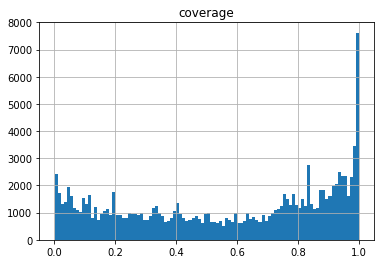

In [15]:
chain_cov.hist(bins=100);